In [439]:
import pandas as pd
import numpy as np

import copy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

import math

In [440]:
def createdf(filename): #створення фрейму
    df = pd.read_csv(filename)
    
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df.isnull().any()
    return(df)

In [441]:
filename = "csv//int20h-ds-test-dataset.csv"

In [442]:
df = createdf(filename)

In [443]:
df["event_created_date"] = pd.to_datetime(df["event_created_date"])

In [444]:
print(str(df.shape[0]) +" rows x " + str(df.shape[1]) + " columns")
df.head()

23357 rows x 8 columns


,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model
0,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Success,"{""Make"":""Dodge"",""Model"":""Caravan"",""Color"":""Whi...",2022-01-16 17:03:04,android,samsung,SM-N975U
1,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Break,{},2022-01-16 17:07:47,android,samsung,SM-N975U
2,f344be2d9a042b7444f3cc5279e38ef1,FL,Calculator View,{},2022-01-16 17:16:25,android,samsung,SM-G973U1
3,c95c777785faec8dd910d019d7278ebe,CA,Add Payment Method Success,"{""Payment Method"":""Credit"",""Tokenized Pay"":""""}",2022-01-16 17:24:22,android,samsung,SM-N975U
4,e331ed81422d8fba55520a43a872e701,IL,Sign Up Success,"{""Method"":""Apple""}",2022-01-16 17:34:51,ios,Apple,"iPhone12,1"


In [445]:
#drop users that have not added, renewed or canceled Subscription Premium - they haven't canceled it because they had no sub

def remove_excess_data(df):
    target_values = ['Subscription Premium Cancel', 'Subscription Premium', 'Subscription Premium Renew', "Order"]
    sign_up_value = "Sign Up Success"
    user_list = df["userid"].unique()
    for i in user_list:
        df_temp = df[df["userid"]==i]
        if target_values[0] in df_temp.values or target_values[1] in df_temp.values:
            continue
        elif target_values[2] in df_temp.values or  target_values[3] in df_temp.values:
            continue
        elif (sign_up_value not in df_temp.values):
            continue
        df = df.drop(df_temp.index)
    return df

In [446]:
#df = remove_excess_data(df)

In [447]:
df = df.sort_values(["userid", "event_created_date"], ascending=[True, True]).reset_index(drop = True)

In [456]:
#Замінюємо невідомі значення пристроїв з яких виконувалися дії 
#користувачів для яких відомий пристрій за іншими діями на ці пристрої
def fill_in_NaNs(df):
    
    for i in range(len(df)):
        if df.loc[i, "event_platform"] == "outofband":
            df_temp = df[df["userid"] == df.iloc[i]["userid"]]
            for index, row in df_temp.iterrows():
                if row["event_platform"] != "outofband":
                    df.loc[i, "event_platform"] = row.at["event_platform"]
                    df.loc[i, "device_manufacture"] = row.at["device_manufacture"]
                    df.loc[i, "device_model"] = row.at["device_model"]
                    break
                    
    df_temp = df[df["user_state"].apply(lambda x: isinstance(x, float))]
    df = df.drop(df_temp.index).reset_index(drop = True)
    #    for index, row in df_temp.iterrows():
    #        if row["user_state"] != np.nan:
    #            temp_state = row["user_state"]
    #            break
    #        df = df.drop(df_temp.index)
    #    df[df["userid"] == user]["user_state"] = temp_state
    
    #states = (df["user_state"].unique()) #nan crutch
    #states = states[~numpy.isnan(states)]
    #for i in range(len(df)):
    #    if isinstance(df.loc[i, "user_state"], float):
    #        df_temp = df[df["userid"] == df.iloc[i]["userid"]]
    #        for index, row in df_temp.iterrows():
    #            if not isinstance(row["user_state"], float):
    #                df.loc[i, "user_state"] = row.at["user_state"]
    #                break
    #            i = i-len(df_temp)
    #            df = df.drop(df_temp.index).reset_index(drop = True)
                
                
    
    return df


In [457]:
df = fill_in_NaNs(df).reset_index(drop = True)
df_canceled = df[df["event_name"] == 'Subscription Premium Cancel']
#print(str(df_canceled.shape[0]) +" rows x " + str(df_canceled.shape[1]) + " columns")
canceled_list = df_canceled["userid"].unique()
df_canceled.head()

,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model
210,03e0c91e1163e8b80e74e586a3e666d6,MD,Subscription Premium Cancel,{},2022-02-24 19:45:02,ios,Apple,"iPhone12,1"
325,051a5f8bce75a601be987980a09d4187,VA,Subscription Premium Cancel,{},2022-04-06 10:12:37,ios,Apple,"iPhone14,2"
346,05630c0e889fe7371fc74d7ae01f491f,FL,Subscription Premium Cancel,{},2022-03-19 18:16:37,ios,Apple,"iPhone13,2"
382,060153cf7a5844d9aed735d408b35f97,TX,Subscription Premium Cancel,{},2022-02-11 15:06:11,ios,Apple,"iPhone14,2"
458,078ae59f1ae79df514e846e5e51eca8b,CA,Subscription Premium Cancel,{},2022-04-09 12:43:36,ios,Apple,"iPhone12,1"


In [459]:
def event_occured_per_user(row):
    if row['userid'] in event_list:
        return 1
    else:
        return 0

In [460]:
def event_occured(row):
    if row["event_name"] == event:
        return 1
    else:
        return 0

In [461]:
event = 'Subscription Premium Cancel'
df_temp = df[df["event_name"] == event]
event_list = df_temp["userid"].unique()
df[event] = df.apply(event_occured_per_user, axis=1)

In [463]:
df.to_csv("csv//sorted_filled_test.csv")

In [464]:
df = createdf("csv//sorted_filled_test.csv")

In [465]:
#виводимо з значення дати значення місяця, квартал, день тижня та час події в хвилинах
def event_created_date_transform(df):
    date = pd.DataFrame({"time" : []})
    date["time"] = pd.to_datetime(df["event_created_date"])
    date["month"] = date["time"].dt.month
    date["quarter"] = date["time"].dt.quarter
    date["day_week"] = date["time"].dt.dayofweek
    #date["time"] = (date["time"].dt.minute.to_numpy(dtype=np.int32) + date["time"].dt.hour.to_numpy(dtype=np.int32)*60)/(60*24) #minute of the day
    date["time"] = date["time"].dt.hour.to_numpy(dtype=np.int32) #hour of the day
    return date

In [466]:
date = event_created_date_transform(df)

In [467]:
date.to_csv("csv//extracted_date_data.csv")

In [468]:
df_canceled = df[df["event_name"] == 'Subscription Premium Cancel']
canceled_list = df_canceled["userid"].unique()

In [469]:
df_time = copy.deepcopy(df)

In [470]:
event = 'Subscription Premium Cancel'
df_time[event] = df_time.apply(event_occured, axis=1)

In [471]:
df_time = df_time.drop(['userid', 'event_name', 'event_attributes',
                        'event_created_date', "user_state", "event_platform","device_manufacture", "device_model"], axis=1)

In [472]:
df_time = pd.concat([df_time, date], axis=1)

In [473]:
df_time.to_csv("csv//event_and_date_data.csv")

In [474]:
df_event_occured = copy.deepcopy(df)
events = df["event_name"].unique()

In [475]:
for e in events:
    event = e
    df_temp = df_event_occured[df_event_occured["event_name"] == event]
    event_list = df_temp["userid"].unique()
    df_event_occured[event] = df_event_occured.apply(event_occured_per_user, axis=1)

In [476]:
df_event_occured = df_event_occured.drop(['event_name', 'event_attributes', 'event_created_date',
                                          "user_state", "event_platform","device_manufacture", "device_model"], axis=1)

In [477]:
df_event_occured = df_event_occured.drop_duplicates(subset = ["userid"])

In [478]:

#fig, ax = plt.subplots(figsize=(15,15))    
#dataplot = sns.heatmap(df_event_occured.drop(["userid"], axis = 1).corr(), cmap="RdYlBu", annot=True, ax = ax)
#plt.show()

In [479]:
df_event_occured.to_csv("csv//event_occured_per_user.csv")

In [480]:
df2 = copy.deepcopy(df)

In [481]:
label_encoder = LabelEncoder()
df_static_data = copy.deepcopy(df2.drop(['userid', 'event_name', 'event_attributes', 'event_created_date'], axis=1))


In [482]:
categories = ["user_state", "event_platform","device_manufacture", "device_model"]
for category in categories:
    #print(df_static_data[category].unique())
    df_static_data[category]=label_encoder.fit_transform(df_static_data[category])
    #print(df_static_data[category].unique())


In [483]:
#dataplot = sns.heatmap(df_static_data.corr(), cmap="RdYlBu", annot=True)
#plt.show()

In [484]:
df_static_data.to_csv("csv//static_data.csv")

In [485]:
df_feature_by_state = copy.deepcopy(df)
events = df["event_name"].unique()

def event_occured_per_state(row):
    if row['user_state'] in event_list:
        return 1
    else:
        return 0

for e in events:
    event = e
    if (event == 'Subscription Premium Cancel'):
        continue
    df_temp = df_feature_by_state[df_feature_by_state["event_name"] == event]
    event_list = df_temp["user_state"].unique()
    df_feature_by_state[event] = df_feature_by_state.apply(event_occured_per_state, axis=1)

In [486]:
df_feature_by_state = df_feature_by_state.drop(['event_attributes', 'event_created_date', 
                                                "event_platform","device_manufacture", "device_model"], axis=1)

In [487]:
#df_feature_by_state = df_feature_by_state.drop_duplicates(subset = ["user_state"])

In [488]:
#df_feature_by_state.groupby(["user_state", 'Subscription Premium Cancel'])["user_state"].count().unstack(fill_value=0).stack()

In [489]:
count = df_feature_by_state.groupby(["user_state", 'Subscription Premium Cancel'])["user_state"].count().unstack(fill_value=0).stack()

In [490]:
len(count)

98

In [491]:
cancel_percentage = [float(count[2*i + 1])/(count[2*i] + count[2*i + 1]) for i in range(int(len(count)/2))]

In [492]:
df_feature_per_state = copy.deepcopy(df_feature_by_state)

df_feature_per_state = df_feature_per_state.drop(['Subscription Premium Cancel', 'Subscription Premium', 'Subscription Premium Renew', 'Sign Up Success'], axis=1)
df_feature_per_state = df_feature_per_state.drop_duplicates(subset = ["user_state"])

df_feature_per_state = df_feature_per_state.drop(['userid', 'event_name'], axis = 1).sort_values(["user_state"]).reset_index(drop = True)
#df_feature_per_state

In [493]:
df_feature_per_state["cancel_percentage"] = cancel_percentage

In [494]:
#df_feature_per_state

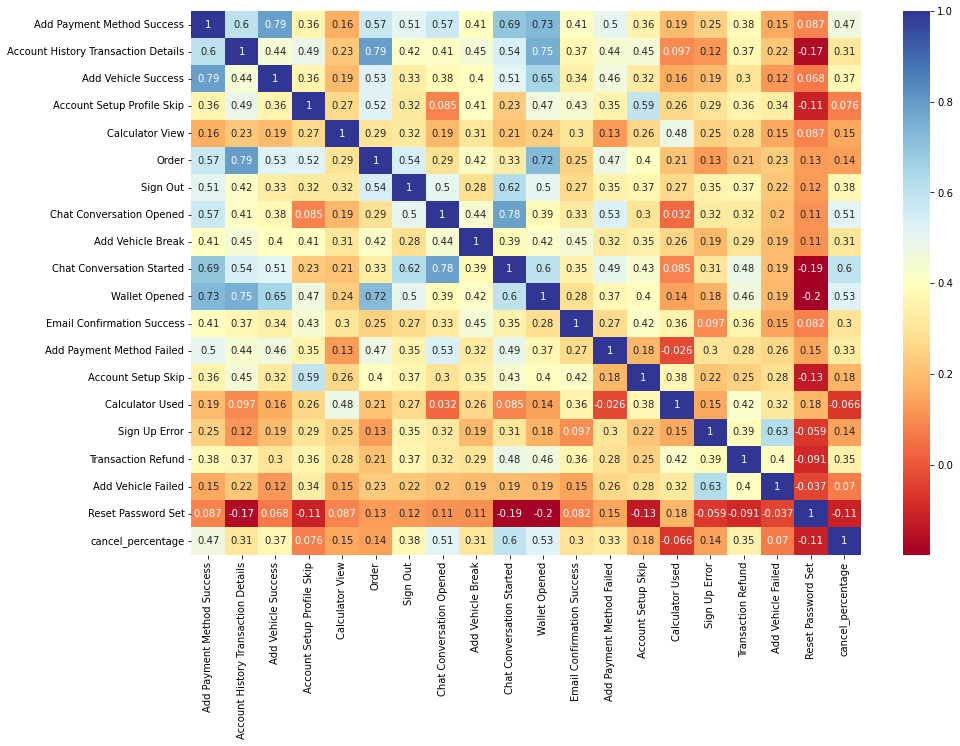

In [495]:
#df_feature_per_state
fig, ax = plt.subplots(figsize=(15,10))    
dataplot = sns.heatmap(df_feature_per_state.corr(), cmap="RdYlBu", annot=True)
plt.show()

In [496]:
df_feature_per_state.corr()["cancel_percentage"]

Add Payment Method Success             0.470548
Account History Transaction Details    0.308735
Add Vehicle Success                    0.371428
Account Setup Profile Skip             0.076048
Calculator View                        0.150526
Order                                  0.135374
Sign Out                               0.376696
Chat Conversation Opened               0.511628
Add Vehicle Break                      0.309864
Chat Conversation Started              0.596676
Wallet Opened                          0.525501
Email Confirmation Success             0.295814
Add Payment Method Failed              0.328621
Account Setup Skip                     0.177554
Calculator Used                       -0.065839
Sign Up Error                          0.139134
Transaction Refund                     0.351462
Add Vehicle Failed                     0.069895
Reset Password Set                    -0.113022
cancel_percentage                      1.000000
Name: cancel_percentage, dtype: float64

In [497]:
#df_feature_by_state = df_feature_by_state.drop_duplicates(subset = ["user_state"])

In [498]:
def remove_excess_events(df):
    target_values = ['Add Vehicle Break', 'Add Vehicle Failed', 'Add Vehicle Success', 
                     "Add Payment Method Failed", "Add Payment Method Success"]
    event_list = df["event_name"].unique()
    for i in event_list:
        df_temp = df[df["event_name"]==i]
        if i in target_values:
            continue
        df = df.drop(df_temp.index)
    return df

In [499]:
df_errors = copy.deepcopy(df)
df_errors = remove_excess_events(df_errors)
count = df_errors.groupby(["userid", "event_name"])["event_name"].count().unstack(fill_value=0).stack()

In [500]:
target_values = ['Add Vehicle Break', 'Add Vehicle Failed', 'Add Vehicle Success', "Add Payment Method Failed", "Add Payment Method Success"]


In [501]:
targer_values_count = [[count[5*j + i] for j in range(int(len(count)/5))] for i in range(5)]

for i in range(int(len(count)/5)):
    if (count[5*i + 2] + count[5*i + 3] + count[5*i + 4]) == 0:
        count[5*i + 2] = 1
    if (count[5*i] + count[5*i + 1]) == 0:
        count[5*i] = 1
error_rate_vehicle = [float(count[5*i + 4])/(count[5*i + 2] + count[5*i + 3] + count[5*i + 4]) for i in range(int(len(count)/5))]
error_rate_payment = [float(count[5*i + 1])/(count[5*i] + count[5*i + 1]) for i in range(int(len(count)/5))]

In [502]:
#print(len(error_rate_vehicle))
#df_errors.drop_duplicates(subset = ["userid"])

In [503]:
df_errors = df_errors.drop_duplicates(subset = ["userid"])
df_errors = df_errors.drop(['event_name', 'event_attributes', 'event_created_date',
                                          "user_state", "event_platform","device_manufacture", "device_model"], axis=1)
df_errors["error_rate_vehicle"] = error_rate_vehicle
df_errors["error_rate_payment"] = error_rate_payment
for i in range(5):
    df_errors[target_values[i]] = targer_values_count[i]

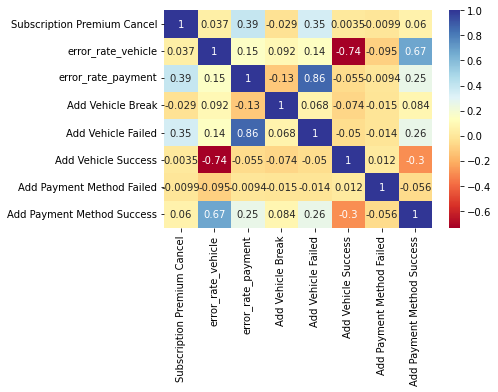

In [504]:
dataplot = sns.heatmap(df_errors.corr(), cmap="RdYlBu", annot=True)
plt.show()

In [505]:
df_errors.to_csv("csv//error_data.csv")

In [506]:
df_feature_per_state.to_csv("csv//feature_per_state.csv")

In [ ]:
df_feature_per_state2 = copy.deepcopy(df_feature_by_state)

In [508]:
df_feature_by_state.to_csv("csv//feature_by_state.csv")